Sentiment Classification



## Annotated data

The dataset contains 1,000 reviews of hotels downloaded from Yelp. Sentiment labels could be one of three classes (positive, negative, neutral). Each review is labeled as:

- **1:** The review expresses a *positive* opinion toward the hotel.
- **0:** The review expresses a mixed or neutral opinion toward the hotel.
- **-1:** The review expresses a *negative* opinion toward the hotel.

I will build classifiers to predict these three classes. A random subset (approximately 10% of the reviews) was selected as test data, while the rest will be used for training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
os.chdir('/content/drive/MyDrive/MachineLearning')

df = pd.read_csv('yelp_hotels1000.csv',
                 header=None, encoding='ISO-8859-1')

df_train = df.loc[df[1] == 'train']
df_test = df.loc[df[1] == 'test']

Y_train = df_train.iloc[0:, 2].values
text_train = df_train.iloc[0:, 3].values

Y_test = df_test.iloc[0:, 2].values
text_test = df_test.iloc[0:, 3].values

## Setting up the classifier

### Tokenization and feature extraction

The function performs two initial preprocessing steps: making the text lowercase (so different capitalizations of words will map to the same feature), and removing consecutive characters that are repeated more than twice (e.g., "woooow" and "wooooooooow" will both map to simply "woow" rather than being counted as separate words).

The function tokenizes words as follows. First, non-alphanumeric characters are replaced with whitespace, then strings separated by whitespace are treated as tokens. Python's `split` function converts a string into a list of tokens that were separated by whitespace. The list of tokens is passed to the `ngrams` function, defined below, which returns a list of all n-grams of length `n` contained in the list. Finally, the function also pulls out tokens containing anything _but_ alphanumeric characters. This will capture punctuation marks and emojis, which may also be useful for classification. These are treated as unigram features rather than longer sequences.

In [ ]:
import re
from collections import Counter

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def features(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice

    features_in_text = []   # running list of all features in this instance (can be repeated)

    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range

    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)

    # now treat punctuation as word tokens, and get their counts (only unigrams)

    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)

    # 'Counter' converts a list into a dictionary whose keys are the list elements
    #  and the values are the number of times each element appeared in the list

    return Counter(features_in_text)


In [ ]:
text = "This is an example of a sentence to tokenize!! Actually, it's more than a sentence, it's two sentences!!!"

print(features(text, ngram_range=(1,2)))

Counter({'a': 2, 'sentence': 2, 'it': 2, 's': 2, 'a sentence': 2, 'it s': 2, '!!': 2, ',': 2, "'": 2, 'this': 1, 'is': 1, 'an': 1, 'example': 1, 'of': 1, 'to': 1, 'tokenize': 1, 'actually': 1, 'more': 1, 'than': 1, 'two': 1, 'sentences': 1, 'this is': 1, 'is an': 1, 'an example': 1, 'example of': 1, 'of a': 1, 'sentence to': 1, 'to tokenize': 1, 'tokenize actually': 1, 'actually it': 1, 's more': 1, 'more than': 1, 'than a': 1, 'sentence it': 1, 's two': 1, 'two sentences': 1})


In [ ]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train = vect.fit_transform(features(d, ngram_range=(1,3)) for d in text_train)

### Classifier and hyperparameter tuning

We will use multinomial logistic regression as our classifier. We will use `sklearn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, setting the `multi_class` argument to `'multinomial'` which tells it to use the multinomial version (otherwise it defaults to binary logistic regression with a one-vs-rest scheme for multiclass data).


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score

base_classifier = LogisticRegression(multi_class='multinomial',
                                     solver='lbfgs', tol=1e-2,
                                     max_iter=500, random_state=123)

# these are the C values we will compare

params = [{'C': [0.01, 0.1, 1.0]}]

# this performs 3-fold cross-validation with the above classifier and parameter options

gs_classifier = GridSearchCV(base_classifier, params, cv=3)
gs_classifier.fit(X_train, Y_train)

print(gs_classifier.get_params())

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 500, 'estimator__multi_class': 'multinomial', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 123, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(max_iter=500, multi_class='multinomial', random_state=123,
                   tol=0.01), 'n_jobs': None, 'param_grid': [{'C': [0.01, 0.1, 1.0]}], 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
Best parameter settings: {'C': 1.0}
Validation accuracy: 0.731440


### N-gram size

As you saw above, the `features` function takes a keyword argument, `ngram_range`, that let's you specify the sizes of n-grams to extract. Experiment with six different ranges of n-gram sizes: (1,1), (2,2), (3,3), (1,2), (1,3), (2,3)

For each n-gram range, you'll need to re-extract and vectorize the features (calling the `features` and `vect.fit_transform` functions, as done above). For each setting, calculate the cross-validation accuracy after using `GridSearchCV` to find the best $C$ value.



In [ ]:

#Define base classifier
base_classifier = LogisticRegression(multi_class = 'multinomial',
                                     solver = 'lbfgs', tol = 1e-2,
                                     max_iter = 500, random_state = 123)

# Specify n-gram ranges
ngram_ranges = [(1, 1), (2, 2), (3, 3), (1, 2), (1, 3), (2, 3)]

# Initalize dict to store results
results = {}

# loop over ranges
for ngram_range in ngram_ranges:
  # Extract and vectorize features
  X_train_ngram = vect.fit_transform(features(d, ngram_range = ngram_range) for d in text_train)
  # Create GridSearchCV object
  gs_classifier = GridSearchCV(base_classifier, params, cv = 3)
  # Perform grid search
  gs_classifier.fit(X_train_ngram, Y_train)
  # Store results in Dict
  results[ngram_range] = gs_classifier.best_score_

# Print results
for ngram_range, accuracy in results.items():
  print(f"N-grams: {ngram_range}\tValidation Accuracy: {accuracy:.6f}")

N-grams: (1, 1)	Validation Accuracy: 0.753913
N-grams: (2, 2)	Validation Accuracy: 0.695502
N-grams: (3, 3)	Validation Accuracy: 0.619104
N-grams: (1, 2)	Validation Accuracy: 0.742667
N-grams: (1, 3)	Validation Accuracy: 0.731440
N-grams: (2, 3)	Validation Accuracy: 0.677534


### Feature selection

Selecting a subset of features can improve classifier efficiency and potentially guard against overfitting. However, it can also hurt performance if too many features are removed. We will now experiment with different levels of feature selection.

We will use the [`SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html) class, which can be used to select features that are within a specified percentile according to a scoring function that ranks the quality of the features. The code below instantiates a `SelectPercentile` object using the [`chi2`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) function, which performs a chi-squared test for measuring the significance of features. The `percentile` argument specifies the percentile of features that are selected after ranking by their chi-squared statistic. If `percentile=1`, only the top 1% of features will be selected. If `percentile=100`, all features will be selected.

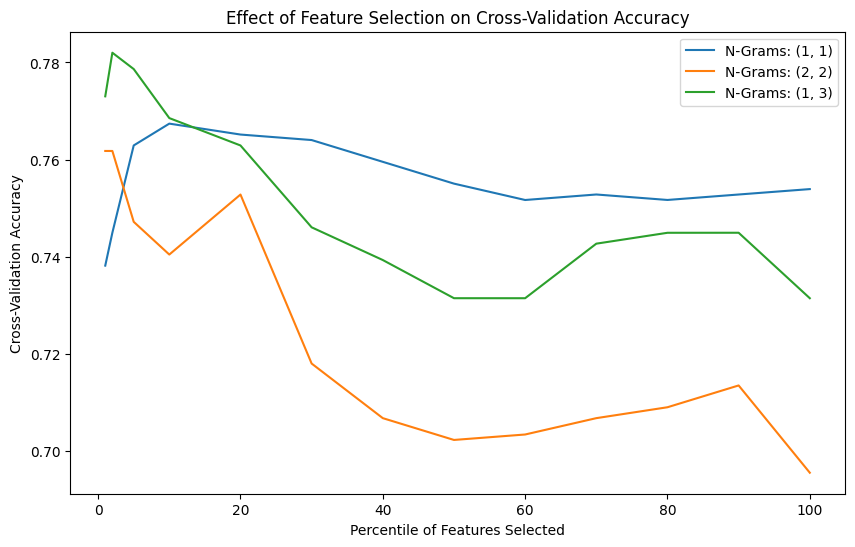

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score

# Define base classifier with settings
base_classifier = LogisticRegression(multi_class='multinomial',
                                     solver='lbfgs', tol=1e-2,
                                     max_iter=500, random_state=123)

# n-gram ranges
ngram_ranges = [(1, 1), (2, 2), (1, 3)]

# Percentiles
percentiles = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize dict to store results
results = {}

# Loop over each n-gram
for ngram_range in ngram_ranges:
  # Extract and vectorize features
  X_train_ngram = vect.fit_transform(features(d, ngram_range=ngram_range) for d in text_train)
  # Initialize List to store results for this range
  accuracies = []

  # Loop over each percentile
  for percentile in percentiles:
    # Create SelectPercentile Object
    selection = SelectPercentile(percentile = percentile, score_func = chi2)
    # Apply feature selection
    X_train_selected = selection.fit_transform(X_train_ngram, Y_train)
    # Create GridSearchCV object
    gs_classifier = GridSearchCV(base_classifier, params, cv = 3)
    # Perform grid search
    gs_classifier.fit(X_train_selected, Y_train)
    # Store accuracies in the list
    accuracies.append(gs_classifier.best_score_)
  # Store results
  results[ngram_range] = accuracies

# Plotting
plt.figure(figsize = (10,6))

# Loop
for ngram_range, accuracies in results.items():
  plt.plot(percentiles, accuracies, label = f"N-Grams: {ngram_range}")
plt.title("Effect of Feature Selection on Cross-Validation Accuracy")
plt.xlabel("Percentile of Features Selected")
plt.ylabel("Cross-Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
ngr = (1,3)
per = 2

Since we are no longer tuning the hyperparameters, now is a reasonable time to also look at the test data. The code below calculates both the cross-validation as well as the accuracy on the test data using the best classifier from cross-validation, using the randomly chosen n-gram and percentile settings.

In [ ]:
X_train_final = vect.fit_transform(features(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.797753
Test accuracy: 0.718182


### Creating new features
- **Skip-grams:** A type of feature that is related to an n-gram is a _skip-gram_. Skip-grams can be defined in different ways, but the definition you will use here is a sequence of word tokens where only the first and last word are specified, while any word token in between is replaced with a general placeholder symbol (usually an asterisk, $*$). For example, the string "the water is cold" contains two length-3 skip-grams ("`the * is`" and "`water * cold`") and one length-4 skip-gram ("`the * * cold`"). The purpose of skip-grams is to capture longer sequences while being general enough to match more instances than with longer n-grams. To implement a skip-gram of length $k$, you can simply extract $k$-grams (i.e., n-grams of length $k$) and replace the inner tokens with asterisks. Like with the n-gram features, the values of the skip-gram features should be their counts. For this assignment, you should extract skip-grams of both length 3 and length 4.
- **Word pairs:** It may be helpful to encode combinations of words that appear in a document, regardless of whether they appear in a particular sequence. One type of feature is to indicate if two words are both present in a text (like doing an *AND* operation on the presense of the two unigrams). For example, the string "the water is cold" contains 6 distinct word pairs ("`(the,water)`", "`(the,is)`", "`(the,cold)`", "`(water,is)`", "`(water,cold)`", "`(is,cold)`"). For full credit, your code should not include pairs that are permutations of each other $-$ for example, include `(water,cold)` or `(cold,water)` but not both. An easy way to do this is to sort the words in alphabetical order within pairs. For this feature, simply use the value $1$ if the pair is present in a text and $0$ otherwise (that is, binary values rather than using full counts).
- **Sentiment dictionary:** One might also take advantage of external resources others have created for sentiment analysis. For this type of feature, we will use a sentiment *lexicon* created by researcher [Bing Liu](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), which is a list of words that have a tendency to show positive sentiment and a list of words with negative sentiment. The lexicon contains thousands of words; the words are already loaded for you in the code cell below. For this feature, you should extract n-grams (using whatever n-gram range was randomly selected above) where any word that appears in the positive dictionary is replaced with the capitalized string "`POS`" and any word in the negative dictionary is replaced with the string "`NEG`". For full credit, you should extract all original n-grams (before doing dictionary replacement) as well as n-grams with the replaced sentiment strings, but without double-counting the original n-grams. For example, the word "cold" is in the negative dictionary, so the string "the water is cold" should have five unigrams all with value $1$ ("`the`", "`water`", "`is`", "`cold`", "`NEG`"), and four bigrams with value with $1$ ("`the water`", "`water is`", "`is cold`", "`is NEG`").

In [ ]:
# (original source: http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar )

sentiment_df = pd.read_csv('sentiment-words.csv', header=None, encoding='ISO-8859-1')

# The two variables, positive_words and negative_words, are sets that contain the positive/negative words

positive_words = sentiment_df.loc[sentiment_df[0] == 'positive']
positive_words = set(positive_words.iloc[0:, 1].values)

negative_words = sentiment_df.loc[sentiment_df[0] == 'negative']
negative_words = set(negative_words.iloc[0:, 1].values)

In [ ]:
# (original source: http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar )

sentiment_df = pd.read_csv('sentiment-words.csv', header=None, encoding='ISO-8859-1')

# The two variables, positive_words and negative_words, are sets that contain the positive/negative words

positive_words = sentiment_df.loc[sentiment_df[0] == 'positive']
positive_words = set(positive_words.iloc[0:, 1].values)

negative_words = sentiment_df.loc[sentiment_df[0] == 'negative']
negative_words = set(negative_words.iloc[0:, 1].values)


def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def features2(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice

    features_in_text = []   # running list of all features in this instance (can be repeated)

    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range

    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)

    # now treat punctuation as word tokens, and get their counts (only unigrams)

    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)

    exclamation_count = text.count('!')
    features_in_text.append(f'exclamation_count:{exclamation_count}')

    # 'Counter' converts a list into a dictionary whose keys are the list elements
    #  and the values are the number of times each element appeared in the list

    return Counter(features_in_text)

X_train_final = vect.fit_transform(features2(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features2(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.803371
Test accuracy: 0.700000


In [ ]:
# Define a few example strings
example_strings = [
    "the water is cold and excellent",
    "positive sentiment words are good",
    "this is a negative example with poor words",
    "testing skip-grams and word pairs",
]

# Iterate over the example strings and print the extracted features
for example_text in example_strings:
    features = features2(example_text, ngram_range=ngr)

    # Print the example text
    print(f"Example Text: {example_text}")

    # Check if any word in the text is in the positive or negative sentiment dictionaries
    for word in example_text.lower().split():
        if word in positive_words:
            print(f"{word}: POS")
        elif word in negative_words:
            print(f"{word}: NEG")

    # Print the extracted features for testing
    for feature, count in features.items():
        print(f"{feature}: {count}")
    print("\n" + "="*40 + "\n")

Example Text: the water is cold and excellent
cold: NEG
excellent: POS
the: 1
water: 1
is: 1
cold: 1
and: 1
excellent: 1
the water: 1
water is: 1
is cold: 1
cold and: 1
and excellent: 1
the water is: 1
water is cold: 1
is cold and: 1
cold and excellent: 1
exclamation_count:0: 1


Example Text: positive sentiment words are good
positive: POS
good: POS
positive: 1
sentiment: 1
words: 1
are: 1
good: 1
positive sentiment: 1
sentiment words: 1
words are: 1
are good: 1
positive sentiment words: 1
sentiment words are: 1
words are good: 1
exclamation_count:0: 1


Example Text: this is a negative example with poor words
negative: NEG
poor: NEG
this: 1
is: 1
a: 1
negative: 1
example: 1
with: 1
poor: 1
words: 1
this is: 1
is a: 1
a negative: 1
negative example: 1
example with: 1
with poor: 1
poor words: 1
this is a: 1
is a negative: 1
a negative example: 1
negative example with: 1
example with poor: 1
with poor words: 1
exclamation_count:0: 1


Example Text: testing skip-grams and word pairs
test